In [1]:
import openslide
import numpy as np 
import matplotlib.pyplot as plt
import PIL
from utils import get_list_of_paths, save_data, load_data
import xml.etree.ElementTree as ET
from shapely.geometry import Point
from shapely.geometry import Polygon 
from tqdm import tqdm


In [2]:
slide_paths = get_list_of_paths('/Volumes/BurhanAnisExtDrive/camelyon/camelyon_data/training/positive/images')
annotation_paths = get_list_of_paths('/Volumes/BurhanAnisExtDrive/camelyon/camelyon_data/training/positive/lesion_annotations')

In [3]:
def in_tumour(x, y, tumour_regions, tile_size):
    """Check if tile center sits inside tumour polygon"""
    center = Point(x + tile_size //2, y + tile_size // 2)
    return any(region.contains(center) for region in tumour_regions)

In [4]:
def parse_annotations(annotation_file):
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    regions = []
    for region in root.findall(".//Annotation"):
        points = []
        for vertex in region.findall(".//Coordinate"):
            x = float(vertex.get("X"))
            y = float(vertex.get("Y"))
            points.append((x, y))
        regions.append(points)
    return regions

In [5]:
slide_paths.sort()
annotation_paths.sort()

In [7]:
slide = openslide.OpenSlide(slide_paths[1])

In [8]:
level = 6
patch_size_level0 = 256
downsample_factor = slide.level_downsamples[level]
patch_size = int(patch_size_level0 / downsample_factor)

In [9]:
regions = parse_annotations(annotation_paths[1])

In [10]:
regions_level = [[(x / downsample_factor, y / downsample_factor) for x, y in region] for region in regions]

In [11]:
pos_regions = [Polygon(polygon) for polygon in regions_level]

In [12]:
width, height = slide.level_dimensions[level]
tiles = []
for x in range(0, width, patch_size):
    for y in range(0, height, patch_size):
        if in_tumour(x, y, pos_regions, patch_size):
            tiles.append((x,y))

In [13]:
tiles_level_0 = [(int(x * downsample_factor), int(y * downsample_factor)) for (x, y) in tiles]

In [14]:
len(tiles_level_0)

16

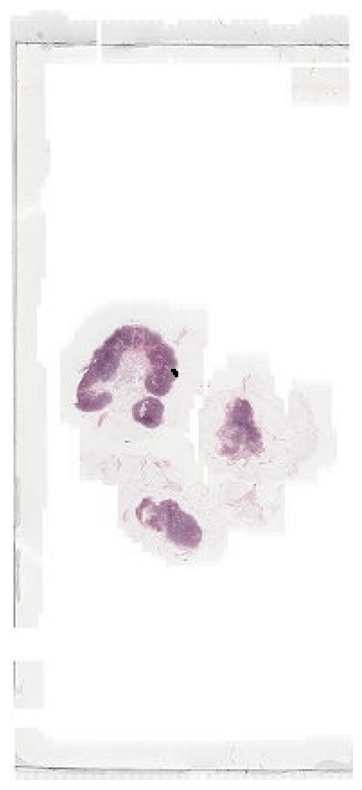

In [15]:
import matplotlib.patches as patches

level = slide.level_count - 1
width, height = slide.level_dimensions[level]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.array(slide.read_region([0,0], level, slide.level_dimensions[level])))
ax.axis('off')
downsample_factor = slide.level_downsamples[level]

# Overlay tiles
for coord in tiles_level_0:
    x, y = coord
    # Scale coordinates to the specified level
    x_level = int(x / downsample_factor)
    y_level = int(y / downsample_factor)

    # Add a rectangle to the plot
    rect = patches.Rectangle(
        (x_level, y_level),  # Top-left corner
        patch_size_level0 / downsample_factor,  # Width
        patch_size_level0 / downsample_factor,  # Height
        linewidth=1.5,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()


In [16]:
slide.close()

In [17]:
tumour_regions = []
for annotation in annotation_paths:
    tumour_regions.append(parse_annotations(annotation))


In [18]:
grid = []
patch_size = 256
# Iterate over each slide and extract tumor region tiles
for slide_path, regions in tqdm(zip(slide_paths, tumour_regions), desc="Getting tumour regions", total=len(slide_paths)):
    try:
        tiles = []
        slide = openslide.OpenSlide(slide_path)
        width, height = slide.dimensions
        pos_regions = [Polygon(polygon) for polygon in regions]
        # Iterate over the slide grid
        for x in range(0, width, patch_size):
            for y in range(0, height, patch_size):
                if in_tumour(x, y, pos_regions, patch_size):
                    tiles.append((x, y))
    
    except Exception as e:
        print(f"⚠️ Error in slide {slide_path}: {e}")
        tiles = None  # Placeholder for error cases


    # Append list of tile coordinates for this slide
    grid.append(tiles)

Getting tumour regions:   0%|          | 0/111 [00:00<?, ?it/s]

Getting tumour regions:  49%|████▊     | 54/111 [12:34<05:16,  5.55s/it]  

⚠️ Error in slide /Volumes/BurhanAnisExtDrive/camelyon/camelyon_data/training/positive/images/tumor_054.tif: A linearring requires at least 4 coordinates.


Getting tumour regions: 100%|██████████| 111/111 [25:27<00:00, 13.76s/it]


In [19]:
len(grid)

111

In [23]:
len(tumour_regions[53])

13

In [30]:
#get the annotation for slide number 54
slide = openslide.OpenSlide(slide_paths[53])
tr = parse_annotations(annotation_paths[53])
tr = [polygon for polygon in tr if len(polygon) >=4]
tr_poly = [Polygon(polygon) for polygon in tr]
width, height = slide.dimensions
tiles = []
for x in range(0, width, patch_size):
    for y in range(0, height, patch_size):
        if in_tumour(x, y, tr_poly, patch_size):
            tiles.append((x,y))

In [31]:
indices = [i for i, val in enumerate(grid) if val is None]

print(indices)  # Output: [1, 3]


[53]


In [32]:
grid[53] = tiles

In [33]:
indices = [i for i, val in enumerate(grid) if val is None]

print(indices)  # Output: [1, 3]

[]


In [34]:
len(grid)

111

In [35]:
save_data('tumour_grid.pkl', grid)

68


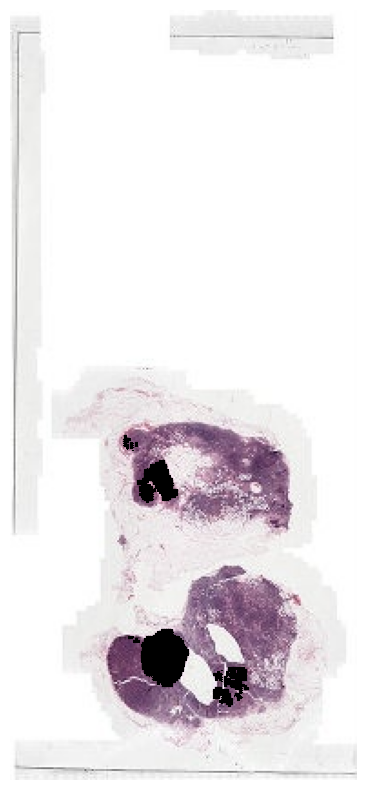

In [36]:
import random 
i = random.randint(0, len(slide_paths) - 1)
print(i + 1)
slide = openslide.OpenSlide(slide_paths[i])
level = slide.level_count - 1
width, height = slide.level_dimensions[level]
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.array(slide.read_region([0,0], level, slide.level_dimensions[level])))
ax.axis('off')
downsample_factor = slide.level_downsamples[level]

# Overlay tiles
for coord in grid[i]:
    x, y = coord
    # Scale coordinates to the specified level
    x_level = int(x / downsample_factor)
    y_level = int(y / downsample_factor)

    # Add a rectangle to the plot
    rect = patches.Rectangle(
        (x_level, y_level),  # Top-left corner
        patch_size_level0 / downsample_factor,  # Width
        patch_size_level0 / downsample_factor,  # Height
        linewidth=1.5,
        edgecolor='black',
        facecolor='none'
    )
    ax.add_patch(rect)

plt.show()

Processing Slide 36: /Volumes/BurhanAnisExtDrive/camelyon/camelyon_data/training/positive/images/tumor_036.tif


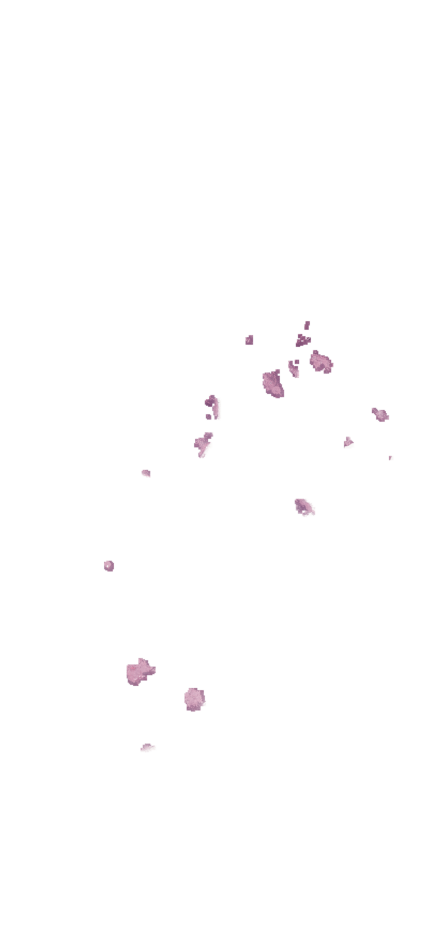

In [53]:
import random
import openslide
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Pick a random slide
i = random.randint(0, len(slide_paths) - 1)
print(f"Processing Slide {i + 1}: {slide_paths[i]}")

# Open the selected WSI
slide = openslide.OpenSlide(slide_paths[i])

# Define level to extract and display at
level = 5  # Choose a mid-resolution level (0 = highest resolution)
downsample_factor = slide.level_downsamples[level]

# Get the slide dimensions at this level
width, height = slide.level_dimensions[level]

# Create a blank white mosaic canvas
mosaic = Image.new("RGB", (width, height), (255, 255, 255))

# Extract tiles and place them in the correct spatial positions
for x, y in grid[i]:
    # Scale coordinates to the selected level
    x_level = int(x / downsample_factor)
    y_level = int(y / downsample_factor)

    # Extract tile at level 0 but place it at level `level`
    tile = slide.read_region((x, y), 0, (1024, 1024)).convert('RGB')

    # Resize tile to match the downsampled level if needed
    tile_size_at_level = (int(1024 / downsample_factor), int(1024 / downsample_factor))
    tile = tile.resize(tile_size_at_level, Image.BILINEAR)

    # Paste into mosaic
    mosaic.paste(tile, (x_level, y_level))

# Display the mosaic
plt.figure(figsize=(12, 12))
plt.imshow(mosaic)
plt.axis('off')
plt.show()
